In [ ]:
  !pip install qiskit

In [ ]:
!pip install pylatexenc

# Qiskit Community Edition

In [ ]:
#@title
import numpy as np

def x_bus(qc,*bus):
    """Negates a whole bus"""
    for q in bus:
        qc.x(q)
        
def bus_or(qc,target,*busses):
    """Negates target if any of input busses is totally true, can add overall phase. Page 16 of reference"""
    if len(busses)==1:
        qc.cnx(qc,*busses[0],target)
    elif len(busses) == 2:
        #negate everything
        qc.x_bus(qc,*busses[0],*busses[1],target)
        qc.ry(np.pi/4,target)
        qc.any_x(qc,*busses[1],target)
        qc.ry(np.pi/4,target)
        qc.any_x(qc,*busses[0],target)
        qc.ry(-np.pi/4,target)
        qc.any_x(qc,*busses[1],target)
        qc.ry(-np.pi/4,target)
        qc.x_bus(qc,*busses[0],*busses[1])
    elif len(busses) >= 3:
        #Need to negate all qubits, do so for each bus
        for bus in busses:
            qc.x_bus(qc,*bus)
        #Then negate the target also
        qc.x(target)
        qc.ry(np.pi/4,target)
        qc.any_x(qc,*busses[1],target)
        qc.ry(np.pi/4,target)
        #Recursiveness here:
        qc.bus_or(qc,target,*busses[:-1])
        qc.ry(-np.pi/4,target)
        qc.any_x(qc,*busses[1],target)
        qc.ry(-np.pi/4,target)
        for bus in busses:
            qc.x_bus(qc,*bus)
        #No need to negate target again
        
def any_x(qc,*qubits):
    """Negate last qubit if any of initial qubits are 1."""
    qc.x_bus(qc,*qubits)
    qc.cnx(qc,*qubits)
    qc.x_bus(qc,*qubits[:-1])
        
def cry(qc,theta,q1,q2):
    """Controlled ry"""
    qc.ry(theta/2,q2)
    qc.cx(q1,q2)
    qc.ry(-theta/2,q2)
    qc.cx(q1,q2)
    
def cnx(qc,*qubits):
    """Control n-1 qubits, apply 'not' to last one
    Follows:
    @article{PhysRevA.52.3457,
      title = {Elementary gates for quantum computation},
      author = {Barenco, Adriano and Bennett, Charles H. and Cleve, Richard and DiVincenzo, David P. and Margolus, Norman and Shor, Peter and Sleator, Tycho and Smolin, John A. and Weinfurter, Harald},
      doi = {10.1103/PhysRevA.52.3457},
      url = {https://link.aps.org/doi/10.1103/PhysRevA.52.3457}
    }
    Follwing Lemma 7.9, which uses Lemma 5.1 and 4.3
    """
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2,qubits[-2],qubits[-1])
        #cry
        qc.cry(qc,np.pi/2,qubits[-2],qubits[-1])
        
        #Control not gate
        qc.cnx(qc,*qubits[:-2],qubits[-1])
        
        #B matrix (cry again, but opposite angle)
        qc.cry(qc,-np.pi/2,qubits[-2],qubits[-1])
        
        #Control
        qc.cnx(qc,*qubits[:-2],qubits[-1])
        
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
        


In [ ]:
#@title
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
import numpy as np

class Move():
    
    def __init__(self,indices,player,q1=None,q2=None):
        """A data structure for game moves"""
        self.indices = indices
        self.player=player
        self.q1=q1
        self.q2=q2
    def __str__(self):
        return str([self.indices,self.player,self.q1,self.q2])
    
class Board():
    
    def __init__(self,x,y,step,print_info=False):
        #quantum register, classical register, quantum circuit.
        self.print_info=print_info
        self.qsize=1
        self.q = QuantumRegister(step,name='qT')
        self.c = ClassicalRegister(step-1,name='c')
        self.qc = QuantumCircuit(self.q, self.c)
        
        self.qc.cry = cry
        self.qc.x_bus = x_bus
        self.qc.cnx = cnx
        self.qc.any_x = any_x
        self.qc.bus_or = bus_or
        #the dimensions of the bord
        self.x=x
        self.y=y
        #To keep track of what is in each cell, no entanglement etc.
        #Provides a graphic of the game state.
        self.cells = np.empty((x,y),dtype=object)
        self.cells[:]='' #Initially game is empty.
        self.game_full = False
        self.moves = []

    def __str__(self):
        return str(self.cells)
        
    def add_move(self,indices,player):
        """Adds a move if it is non-clashing, otherwise passes it on"""
        for index in indices:
            if index[0] >= self.x:
                return 'Index out of range'
            if index[1] >= self.y:
                return 'Index out of range'
        status = self._add_move(indices,player)
        if status=='ok':
            if player==0:
                char = 'X'
            elif player==1:
                char = 'O'
            char+=str(len(self.moves))
            for index in indices:
                s = self.cells[index[0],index[1]]
                if s: #If the cell has some text
                    #Add char with a comma
                    self.cells[index[0],index[1]]+=' '+char
                else: #cell is empty so just add char
                    self.cells[index[0],index[1]]+=char
            print(self.cells)
                
        return status
    def _add_move(self,indices,player):
        """Actually adds the move if not clashing,
        otherwise passes it to _add_clashing_move"""
        if len(indices)==2:
            if indices[0]==indices[1]:
                indices = [indices[0]]
        num=len(indices)
        caught_clashes = False #turns true if all moves are safe clashes
        for existing_move in self.moves:
            for index in indices:
                if index in existing_move.indices:
                    if len(existing_move.indices)==1:
                        return 'overfull'
                        #This move will ALWAYS be there, if it can.
                        #hence, overfull.
                    else:
                        #captures any clash
                        caught_clashes = True
        if caught_clashes:
            return self._add_clashing_move(indices,player)
        else:
            #Reach this section if there are no clashes at all
            if num==1:
                self.moves.append(Move(indices,player)) #No control needed
                return 'ok'
            else:
                self.qsize+=2 #indicator qubit, and move qubit
                q1 = self.q[self.qsize-2] #To make this readable...
                q2 = self.q[self.qsize-1]
                self.qc.h(q1) #the last qubit in register.
                self.qc.x(q2)
                self.qc.cx(q1,q2)
                self.moves.append(Move(indices,player,q1,q2))
                return 'ok'
        
    def _add_clashing_move(self,indices,player):
        """Adds a clashing move"""
        if len(indices)==1: #100% of qubit is on one clashing spot.
            #This spot COULD be occupied.
            self.qsize+=1 #Only one bit needed, move happens or not.
            index = indices[0]
            bus = []
            for existing_move in self.moves:
                if index in existing_move.indices:
                    if index==existing_move.indices[0]:
                        bus.append(existing_move.q1)
                    elif index==existing_move.indices[1]:
                        bus.append(existing_move.q2)
            #Now if any entry on the bus is true, our qubit is false.
            self.qc.x(self.q[self.qsize-1]) # make it 1
            self.qc.any_x(self.qc,*bus,self.q[self.qsize-1])
            #negate is any dependents are true.
            #So the new move can happen if none of the others happen.
            self.moves.append(Move(indices,player,self.q[self.qsize-1]))
            return 'ok'
        elif len(indices)==2:
            #Check first spot is not occupied, then second spot if first
            #is not occupied.
            
            self.qsize+=2 #Two bits needed (maybe) for each index.
            
            #This can be optimized, in effect only one qubit is needed,
            #and its result indicates the selected qubit.
            #However, then some control qubit is needed too.
            #Since there are moves that could possibly be erased completely!
            bus0 = []
            bus1 = []
            for existing_move in self.moves:
                if indices[0] in existing_move.indices:
                    if indices[0]==existing_move.indices[0]:
                        bus0.append(existing_move.q1)
                    elif indices[0]==existing_move.indices[1]:
                        bus0.append(existing_move.q2)
                if indices[1] in existing_move.indices:
                    if indices[1]==existing_move.indices[0]:
                        bus1.append(existing_move.q1)
                    elif indices[1]==existing_move.indices[1]:
                        bus1.append(existing_move.q2)
            #Now if any entry on the bus is true, our first qubit is false.
            q1 = self.q[self.qsize-2] #a bit easier to look at (:
            q2 = self.q[self.qsize-1]
            if bus0:
                self.qc.x(q1)
                self.qc.cnx(self.qc,*bus0,q1)
            else: self.qc.h(q1)
            #And now the second qubit is 1 only if none of its competitors
            #are 1, and likewise if the previous qubit is zero.
            self.qc.x(q2)
            self.qc.bus_or(self.qc,q2,bus1,[q1])
            self.moves.append(Move(indices,player,q1,q2))
            return 'ok'
        
    def run(self):
        """Game loop"""
        self.running=True
        if self.print_info:
            print("Welcome to Quantum tic tac toe!")
            print("At each turn choose if to make one or two moves.")
            print("Playing one move at a time is a classic tic tac toe game.")
            print("At each turn the game state is printed.")
            print("This constitutes a 3x3 grid (standard game!).")
            print("You will see empty cells if no move was made on that part of the board.")
            print("Moves made by X are marked with Xi, 'i' some number.")
            print("e.g. X3 is the third move, played by X. When a move is made in a super position,")
            print("You will see its label, say X3, appear in several places.")
            print("This means your move is in a superposition of two classical moves!")
            print("A superposition of classical moves does not guarantee that a spot is occupied,")
            print("so other players can attempt to occupy it too.")
            print("Then the new move will be anti-correlated with the move already in that spot.")
            print("And so the game branches out into many simultaneous states.")
            print("The outcome is then computed by simulation...")
            print("so don't make too many quantum moves or it will take long to compute!")
            print("Enter 'q' at any time to quit")
            print("Enter 'end' to end the game, and compute the winner(s).")
            print("Good luck!")
        while self.running:
            self.ask_player(0)
            self.ask_player(1)
        if self.game_full:
            self.compute_winner()
                
    def ask_player(self,player):
        """Ask a player for move details"""
        asking=False
        if self.running:
            asking = True
        while asking:
            if player==0:
                player_name = 'X'
            elif player==1:
                player_name = 'O'
            print("PLAYER "+player_name+" :")
            cells = self.question('Play in 1 or 2 cells?')
            if cells=='1':
                x = int(self.question('x index:'))
                y = int(self.question('y index:'))
                status = self.add_move([[y,x]],player)
                if status == 'ok':
                    asking = False
                else: print(status)
            elif cells=='2':
                x1 = int(self.question('x1 index:'))
                y1 = int(self.question('y1 index:'))
                x2 = int(self.question('x2 index:'))
                y2 = int(self.question('y2 index:'))
                status = self.add_move([[y1,x1],[y2,x2]],player)
                if status == 'ok':
                    asking = False
                else: print(status)
                
            if not self.running:
                asking=False
        
    def question(self,text):
        """ask user a question"""
        if self.running:
            answer = input(text)
            if answer=='q':
                self.running=False
                return None
            elif answer=='end':
                self.game_full = True
                self.running = False
            else:
                return answer
        else: return None
    
    def compute_winner(self):
        """Find overall game winner, by finding winners of each outcome"""
        #self.csize = self.qsize #Make them the same
        self.qc.measure(self.q[1:], self.c) #Measure
        backend = Aer.get_backend('qasm_simulator')
        
        job_sim = execute(self.qc, backend=backend, shots=100)
        sim_result = job_sim.result()
        print("simulation: ", sim_result)
        print(sim_result.get_counts(self.qc))
        self.counts = sim_result.get_counts(self.qc)
        for count in self.counts: #Takes key names
            c = list(count)[:-1] #splits key '1011' => ['1','0','1','1']
            c = c[::-1] #invert it so it goes 0 up...
            #Ignore the last bit since I dont know how to get rid of it
            #It is zero always.
            #The reason it is included is that I create a quantum register and
            #then start adding operations, quantum registers need at least one bit.
            counter = 0
            weight = self.counts[count]
            empty = np.zeros((self.x,self.y),dtype=str)
            for m in self.moves:
                if m.player == 0:
                    char = 'x'
                elif m.player==1:
                    char = 'o'
                result = []
                if m.q1:
                    result.append(c[counter])
                    counter+=1
                if m.q2:
                    result.append(c[counter])
                    counter+=1
                #print(result)
                if len(result) == len(m.indices):
                    #print(m)
                    if result[0]=='1':
                        empty[m.indices[0][0],m.indices[0][1]] = char
                    if len(result)>1:
                        if result[1]=='1':
                            if result[0]=='1':
                                print('problem! a move appeard in two places.')
                                print(m)
                            empty[m.indices[1][0],m.indices[1][1]] = char
                elif not result: #Then it was a classcal move
                    empty[m.indices[0][0],m.indices[0][1]] = char
            xscore,oscore=self.winners(empty)
            print('X wins: '+str(xscore))
            print('O wins: '+str(oscore))
            print('Shots: '+str(weight))
            print(empty)
    
    def winners(self,empty):
        """Compute winners of a board"""
        oscore = 0
        xscore = 0
        for x in range(self.x):
            if empty[x,1]==empty[x,0] and empty[x,2]==empty[x,1]:
                if empty[x,0]=='o':
                    oscore+=1
                elif empty[x,0]=='x':
                    xscore +=1
        for y in range(self.y):
            if empty[1,y]==empty[0,y] and empty[2,y]==empty[0,y]:
                if empty[0,y]=='o':
                    oscore+=1
                elif empty[0,y]=='x':
                    xscore +=1
        if empty[0,0]==empty[1,1] and empty[1,1]==empty[2,2]:
            if empty[0,0]=='o':
                oscore+=1
            elif empty[0,0]=='x':
                xscore += 1
        if empty[2,0]==empty[1,1] and empty[1,1]==empty[0,2]:
            if empty[2,0]=='o':
                oscore+=1
            elif empty[2,0]=='x':
                xscore += 1
        return [xscore,oscore]

    def _populate_board(self):
        """Automatically populate as below, for testing purposes"""
        self.add_move([[2,2],[0,0]],1)
        self.add_move([[1,1],[1,2]],0)
        '''self.add_move([[1,2],[2,1]],1)
        self.add_move([[2,1]],0)
        self.add_move([[0,1]],1)
        self.add_move([[1,0]],0)
        self.add_move([[2,0]],1)
        self.add_move([[2,2]],0)
        self.add_move([[0,0]],1)
        self.add_move([[0,2]],0)
        self.add_move([[1,1]],1)
        self.add_move([[1,2]],0)'''
    
#if __name__=="__main__":
    #B= Board(3,3)
    #B.run()
    #B._populate_board()
    #a = B.compute_winner()

#修改版

In [ ]:
#@title
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
import numpy as np
import pandas as pd

class Move():
    
    def __init__(self,indices,player,q1=None,q2=None):
        """A data structure for game moves"""
        self.indices = indices
        self.player=player
        self.q1=q1
        self.q2=q2
    def __str__(self):
        return str([self.indices,self.player,self.q1,self.q2])
    
class Board():
    
    def __init__(self,x,y,step,print_info=False):
        #quantum register, classical register, quantum circuit.
        self.print_info=print_info
        self.qsize=0
        self.q = QuantumRegister(step,name='qT')
        self.c = ClassicalRegister(step,name='c')
        self.qc = QuantumCircuit(self.q, self.c)
        
        self.qc.cry = cry
        self.qc.x_bus = x_bus
        self.qc.cnx = cnx
        self.qc.any_x = any_x
        self.qc.bus_or = bus_or
        #the dimensions of the bord
        self.x=x
        self.y=y
        #To keep track of what is in each cell, no entanglement etc.
        #Provides a graphic of the game state.
        self.cells = np.empty((x,y),dtype=object)
        self.cells[:]='' #Initially game is empty.
        self.game_full = False
        self.moves = []

    def __str__(self):
        return str(self.cells)
        
    def add_move(self,indices,player):
        """Adds a move if it is non-clashing, otherwise passes it on"""
        for index in indices:
            if index[0] >= self.x:
                return 'Index out of range'
            if index[1] >= self.y:
                return 'Index out of range'
        status = self._add_move(indices,player)
        if status=='ok':
            if player==0:
                char = 'X'
            elif player==1:
                char = 'O'
            subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
            char+=str(len(self.moves)).translate(subscript)
            for index in indices:
                s = self.cells[index[0],index[1]]
                if s: #If the cell has some text
                    #Add char with a comma
                    self.cells[index[0],index[1]]+=' '+char
                else: #cell is empty so just add char
                    self.cells[index[0],index[1]]+=char
            #print(self.cells)
            print('step{}:'.format(len(self.moves)))
            df=pd.DataFrame(B.cells)
            display(df)
            print()
            
        return status
    def _add_move(self,indices,player):
        """Actually adds the move if not clashing,
        otherwise passes it to _add_clashing_move"""
        if len(indices)==2:
            if indices[0]==indices[1]:
                indices = [indices[0]]
        num=len(indices)
        caught_clashes = False #turns true if all moves are safe clashes
        for existing_move in self.moves:
            for index in indices:
                if index in existing_move.indices:
                    if len(existing_move.indices)==1:
                        return 'overfull'
                        #This move will ALWAYS be there, if it can.
                        #hence, overfull.
                    else:
                        #captures any clash
                        caught_clashes = True
        if caught_clashes:
            return self._add_clashing_move(indices,player)
        else:
            #Reach this section if there are no clashes at all
            if num==1:
                self.moves.append(Move(indices,player)) #No control needed
                return 'ok'
            else:
                self.qsize+=2 #indicator qubit, and move qubit
                q1 = self.q[self.qsize-2] #To make this readable...
                q2 = self.q[self.qsize-1]
                self.qc.h(q1) #the last qubit in register.
                self.qc.x(q2)
                self.qc.cx(q1,q2)
                self.moves.append(Move(indices,player,q1,q2))
                return 'ok'
        
    def _add_clashing_move(self,indices,player):
        """Adds a clashing move"""
        if len(indices)==1: #100% of qubit is on one clashing spot.
            #This spot COULD be occupied.
            self.qsize+=1 
            index = indices[0]
            bus = []
            for existing_move in self.moves:
                if index in existing_move.indices:
                    if index==existing_move.indices[0]:
                        bus.append(existing_move.q1)
                    elif index==existing_move.indices[1]:
                        bus.append(existing_move.q2)
            #Now if any entry on the bus is true, our qubit is false.
            self.qc.x(self.q[self.qsize-1]) # make it 1
            self.qc.any_x(self.qc,*bus,self.q[self.qsize-1])
            #negate is any dependents are true.
            #So the new move can happen if none of the others happen.
            self.moves.append(Move(indices,player,self.q[self.qsize-1]))
            return 'ok'
        elif len(indices)==2:
            #Check first spot is not occupied, then second spot if first
            #is not occupied.
            
            self.qsize+=2 #Two bits needed for each index.
            
            #This can be optimized, in effect only one qubit is needed,
            #and its result indicates the selected qubit.
            #However, then some control qubit is needed too.
            #Since there are moves that could possibly be erased completely!
            bus0 = []
            bus1 = []
            for existing_move in self.moves:
                if indices[0] in existing_move.indices:
                    if indices[0]==existing_move.indices[0]:
                        bus0.append(existing_move.q1)
                    elif indices[0]==existing_move.indices[1]:
                        bus0.append(existing_move.q2)
                if indices[1] in existing_move.indices:
                    if indices[1]==existing_move.indices[0]:
                        bus1.append(existing_move.q1)
                    elif indices[1]==existing_move.indices[1]:
                        bus1.append(existing_move.q2)
            #Now if any entry on the bus is true, our first qubit is false.
            q1 = self.q[self.qsize-2] #a bit easier to look at (:
            q2 = self.q[self.qsize-1]
            if bus0:
                self.qc.x(q1)
                self.qc.cnx(self.qc,*bus0,q1)
            else: self.qc.h(q1)
            #And now the second qubit is 1 only if none of its competitors
            #are 1, and likewise if the previous qubit is zero.
            self.qc.x(q2)
            self.qc.barrier()
            self.qc.bus_or(self.qc,q2,bus1,[q1])
            self.moves.append(Move(indices,player,q1,q2))
            return 'ok'
    
    def compute_winner(self):
        """Find overall game winner, by finding winners of each outcome"""
        self.qc.measure(self.q, self.c) #Measure c[1:]
        backend = Aer.get_backend('qasm_simulator')
        
        job_sim = execute(self.qc, backend=backend, shots=100)
        sim_result = job_sim.result()
       # print("simulation: ", sim_result)
        print(sim_result.get_counts(self.qc))
        self.counts = sim_result.get_counts(self.qc)
        for count in self.counts: #Takes key names
            c = list(count)
            counter = 0
            weight = self.counts[count]
            empty = np.zeros((self.x,self.y),dtype=str)
            for m in self.moves:
                if m.player == 0:
                    char = 'x'
                elif m.player==1:
                    char = 'o'
                result = []
                if m.q1:
                    result.append(c[counter])
                    counter+=1
                if m.q2:
                    result.append(c[counter])
                    counter+=1
                #print(result)
                if len(result) == len(m.indices):
                    #print(m)
                    if result[0]=='1':
                        empty[m.indices[0][0],m.indices[0][1]] = char
                    if len(result)>1:
                        if result[1]=='1':
                            if result[0]=='1':
                                print('problem! a move appeard in two places.')
                                print(m)
                            empty[m.indices[1][0],m.indices[1][1]] = char
                elif not result: #Then it was a classcal move
                    empty[m.indices[0][0],m.indices[0][1]] = char
            xscore,oscore=self.winners(empty)
            print('X wins: '+str(xscore))
            print('O wins: '+str(oscore))
            #print('Shots: '+str(weight))
            #print(empty)
            print('\nProb:{}%'.format(weight))
            df=pd.DataFrame(empty)
            display(df)
    
    def winners(self,empty):
        """Compute winners of a board"""
        oscore = 0
        xscore = 0
        for x in range(self.x):
            if empty[x,1]==empty[x,0] and empty[x,2]==empty[x,1]:
                if empty[x,0]=='o':
                    oscore+=1
                elif empty[x,0]=='x':
                    xscore +=1
        for y in range(self.y):
            if empty[1,y]==empty[0,y] and empty[2,y]==empty[0,y]:
                if empty[0,y]=='o':
                    oscore+=1
                elif empty[0,y]=='x':
                    xscore +=1
        if empty[0,0]==empty[1,1] and empty[1,1]==empty[2,2]:
            if empty[0,0]=='o':
                oscore+=1
            elif empty[0,0]=='x':
                xscore += 1
        if empty[2,0]==empty[1,1] and empty[1,1]==empty[0,2]:
            if empty[2,0]=='o':
                oscore+=1
            elif empty[2,0]=='x':
                xscore += 1
        return [xscore,oscore]

#最終版 （Cswap

In [ ]:
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
import numpy as np
import pandas as pd

class Move():
    
    def __init__(self,indices,player,q1=None,q2=None):
        """A data structure for game moves"""
        self.indices = indices
        self.player=player
        self.q1=q1
        self.q2=q2
    def __str__(self):
        return str([self.indices,self.player,self.q1,self.q2])
    
class Board():
    
    def __init__(self,x,y,step,print_info=False):
        #quantum register, classical register, quantum circuit.
        self.print_info=print_info
        self.qsize=0
        self.step=step
        self.q = QuantumRegister(step*2,name='qT')
        self.c = ClassicalRegister(step*2,name='c')
        self.a = QuantumRegister(1,name='ancilla')
        self.qc = QuantumCircuit(self.q, self.a, self.c)
        
        #the dimensions of the bord
        self.x=x
        self.y=y
        #To keep track of what is in each cell, no entanglement etc.
        #Provides a graphic of the game state.
        self.cells = np.empty((x,y),dtype=object)
        self.cells[:]='' #Initially game is empty.
        self.game_full = False
        self.moves = []

    def __str__(self):
        return str(self.cells)
        
    def add_move(self,indices,player):
        """Adds a move if it is non-clashing, otherwise passes it on"""
        for index in indices:
            if index[0] >= self.x:
                return 'Index out of range'
            if index[1] >= self.y:
                return 'Index out of range'
        status = self._add_move(indices,player)
        if status=='ok':
            if player==0:
                char = 'X'
            elif player==1:
                char = 'O'
            subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
            char+=str(len(self.moves)).translate(subscript)
            for index in indices:
                s = self.cells[index[0],index[1]]
                if s: #If the cell has some text
                    #Add char with a comma
                    self.cells[index[0],index[1]]+=' '+char
                else: #cell is empty so just add char
                    self.cells[index[0],index[1]]+=char
            #print(self.cells)
            print('step{}:'.format(len(self.moves)))
            df=pd.DataFrame(B.cells)
            display(df)
            print()
            
        return status
    def _add_move(self,indices,player):
        """Actually adds the move if not clashing,
        otherwise passes it to _add_clashing_move"""
        if len(indices)==2:
            if indices[0]==indices[1]:
                indices = [indices[0]]
        num=len(indices)
        caught_clashes = False #turns true if all moves are safe clashes
        for existing_move in self.moves:
            for index in indices:
                if index in existing_move.indices:
                    if len(existing_move.indices)==1:
                        return 'overfull'
                        #This move will ALWAYS be there, if it can.
                        #hence, overfull.
                    else:
                        #captures any clash
                        caught_clashes = True
        if caught_clashes:
            return self._add_clashing_move(indices,player)
        else:
            #Reach this section if there are no clashes at all
            if num==2:
                self.qsize+=2 #indicator qubit, and move qubit
                q1 = self.q[self.qsize-2] #To make this readable...
                q2 = self.q[self.qsize-1]
                self.qc.h(q1) #the last qubit in register.
                self.qc.x(q2)
                self.qc.cx(q1,q2)
                self.moves.append(Move(indices,player,q1,q2))
                return 'ok'
    def _clash_move(self,q_exist,q,q_o):
      self.qc.ccx(q_exist,q,self.a)
      self.qc.cswap(self.a,q,q_o)   
      self.qc.reset(self.a)     
    def _add_clashing_move(self,indices,player):
        if len(indices)==2:
            
            self.qsize+=2 #Two bits needed for each index.
            
            q1 = self.q[self.qsize-2] 
            q2 = self.q[self.qsize-1]
            self.qc.h(q1) 
            self.qc.x(q2)
            self.qc.cx(q1,q2)
            for existing_move in self.moves:
                if indices[0] in existing_move.indices:
                    if indices[0]==existing_move.indices[0]:
                        self._clash_move(existing_move.q1,q1,q2)
                    elif indices[0]==existing_move.indices[1]:
                        self._clash_move(existing_move.q2,q1,q2)
                if indices[1] in existing_move.indices:
                    if indices[1]==existing_move.indices[0]:
                        self._clash_move(existing_move.q1,q2,q1)
                    elif indices[1]==existing_move.indices[1]:
                        self._clash_move(existing_move.q2,q2,q1)
            self.moves.append(Move(indices,player,q1,q2))
            return 'ok'
    
    def compute_winner(self):
        """Find overall game winner, by finding winners of each outcome"""
        self.qc.measure(self.q[:self.qsize], self.c[:self.qsize]) #Measure 
        backend = Aer.get_backend('qasm_simulator')
        
        job_sim = execute(self.qc, backend=backend, shots=100)
        sim_result = job_sim.result()
       # print("simulation: ", sim_result)
        print(sim_result.get_counts(self.qc))
        self.counts = sim_result.get_counts(self.qc)
        for count in self.counts: #Takes key names
            c = list(count)
            c = c[-self.qsize:]
            counter = 0
            weight = self.counts[count]
            empty = np.zeros((self.x,self.y),dtype=str)
            for m in self.moves:
                if m.player == 0:
                    char = 'x'
                elif m.player==1:
                    char = 'o'
                result = []
                if m.q1:
                    result.append(c[counter])
                    counter+=1
                if m.q2:
                    result.append(c[counter])
                    counter+=1
                print(result)
                if len(result) == len(m.indices):
                    #print(m)
                    if result[0]=='1':
                        empty[m.indices[0][0],m.indices[0][1]] = char
                    if len(result)>1:
                        if result[1]=='1':
                            if result[0]=='1':
                                print('problem! a move appeard in two places.')
                                print(m)
                            empty[m.indices[1][0],m.indices[1][1]] = char
            print('\nProb:{}%'.format(weight))
            df=pd.DataFrame(empty)
            display(df)

#Practice

In [ ]:
B= Board(3,3,3) #3*3方格 最多下三手

B.add_move([[0,0],[0,2]],1)
B.add_move([[0,2],[0,1]],0)

#B.add_move([[0,0],[0,1]],1)
#B.add_move([[0,1],[0,0]],0)

a = B.compute_winner()

step1:


,0,1,2
0,O₁,,O₁
1,,,
2,,,



step2:


,0,1,2
0,O₁,X₂,O₁ X₂
1,,,
2,,,



{'001010': 52, '001001': 26, '000101': 22}
['1', '0']
['1', '0']

Prob:52%


,0,1,2
0,o,,x
1,,,
2,,,


['1', '0']
['0', '1']

Prob:26%


,0,1,2
0,o,x,
1,,,
2,,,


['0', '1']
['0', '1']

Prob:22%


,0,1,2
0,,x,o
1,,,
2,,,


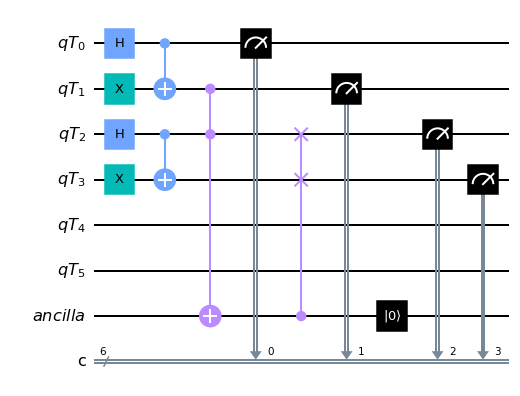

In [ ]:
%matplotlib inline
import pylatexenc
B.qc.draw(output= 'mpl')

In [ ]:
B= Board(3,3,4) #3*3方格 最多下四手

B.add_move([[0,0],[0,2]],1)
B.add_move([[0,2],[0,1]],0)
B.add_move([[0,1],[2,1]],1)
B.add_move([[2,1],[1,1]],0)

a = B.compute_winner()

step1:


,0,1,2
0,O₁,,O₁
1,,,
2,,,



step2:


,0,1,2
0,O₁,X₂,O₁ X₂
1,,,
2,,,



step3:


,0,1,2
0,O₁,X₂ O₃,O₁ X₂
1,,,
2,,O₃,



step4:


,0,1,2
0,O₁,X₂ O₃,O₁ X₂
1,,X₄,
2,,O₃ X₄,



{'10010101': 7, '10101001': 23, '01010101': 7, '10100101': 13, '10101010': 50}
['1', '0']
['0', '1']
['0', '1']
['0', '1']

Prob:7%


,0,1,2
0,o,x,
1,,x,
2,,o,


['1', '0']
['1', '0']
['1', '0']
['0', '1']

Prob:23%


,0,1,2
0,o,o,x
1,,x,
2,,,


['0', '1']
['0', '1']
['0', '1']
['0', '1']

Prob:7%


,0,1,2
0,,x,o
1,,x,
2,,o,


['1', '0']
['1', '0']
['0', '1']
['0', '1']

Prob:13%


,0,1,2
0,o,,x
1,,x,
2,,o,


['1', '0']
['1', '0']
['1', '0']
['1', '0']

Prob:50%


,0,1,2
0,o,o,x
1,,,
2,,x,


# SWAP gate

|00⟩ ⇒ |01⟩

In [ ]:
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute

q=QuantumRegister(4)
a=QuantumRegister(1)
c=ClassicalRegister(4)
qc=QuantumCircuit(q,a,c)
qc.h(q[0])
qc.x(q[1])
qc.cx(q[0],q[1])


qc.h(q[2])
qc.x(q[3])
qc.cx(q[2],q[3])


qc.ccx(q[1],q[2],a)
qc.cswap(a,q[2],q[3])
qc.measure(q,c)
backend = Aer.get_backend('qasm_simulator')
        
job_sim = execute(qc, backend=backend, shots=100)
sim_result = job_sim.result()
print("simulation: ", sim_result.get_counts())

simulation:  {'0101': 19, '1010': 50, '1001': 31}


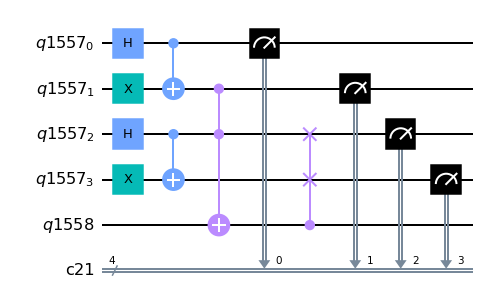

In [ ]:
%matplotlib inline
import pylatexenc
qc.draw(output= 'mpl')